In [ ]:
%matplotlib inline


# Two dimension dam break study case.

The dam break is known to be difficult to solve numericaly due to its initial
discontinuity.

It simulate the behavior of a column of fluid confined by wall. At the initial
time, the wall is removed, leading to a wave propagation.

The shallow water equation will modelise the fluid dynamic and is described
by the equation below :

\begin{align}\begin{cases}
        \frac{\partial h}{\partial t} + \frac{\partial h}{\partial x} + \frac{\partial h}{\partial y} &= 0 \\
        \frac{\partial u}{\partial t} + u\,\frac{\partial u}{\partial x} + v\,\frac{\partial u}{\partial y} &= -g\,\frac{\partial h}{\partial x}\\
        \frac{\partial v}{\partial t} + u\,\frac{\partial v}{\partial x} + v\,\frac{\partial v}{\partial y} &= -g\,\frac{\partial h}{\partial y}
    \end{cases}\end{align}

This example will focus on 2D dam break, with wall at the boundaries (simulated
as no-flux boundary) and a curved dam.


In [2]:
from skfdiff import Model, Simulation
import numpy as np
from scipy.ndimage import gaussian_filter
import pylab as plt

c:\Users\kim9y\AppData\Local\Programs\Python\Python310\lib\site-packages\skfdiff\core\backends\__init__.py:10: UserWarning: Numba cannot be imported: numba backend will not be available.
  warnings.warn("Numba cannot be imported: numba backend will not be available.")


Zarr module not found, ZarrContainer not available.


## Model definition

The PDE has to be written. It is just the RHS of the model as defined earlier
written as $\frac{\partial U}{\partial t} = F(U)$.
Moreover, in that specific case, we will also specify that the advective
terms has to be discretized with an upwind scheme to mitigate the numerical
errors that will occur at the discontinuity. This is especially needed as
we do not have diffusion at all in the model that could smooth the numerical
errors.

### Boundary conditions

The boundary condition will be empty, and will fallback to scikit-fdiff
default (no-flux condition at every boundaries).



In [4]:
shallow_2D = Model(
    [
        "-dx(h * u) - dy(h * v)",
        "-upwind(u, u, x, 2) - upwind(v, u, y, 2) - g * dxh",
        "-upwind(u, v, x, 2) - upwind(v, v, y, 2) - g * dyh",
    ],
    ["h(x, y)", "u(x, y)", "v(x, y)"],
    parameters=["g"],
)

## Filter post-process

As the discontinuity will be still harsh to handle by a "simple" finite
difference solver (a finite volume solver is usually the tool you will need),
we will use a gaussian filter that will be applied to the fluid height. This
will smooth the oscillation (generated by numerical errors). This can be seen
as a way to introduce numerical diffusion to the system, often done by adding
a diffusion term in the model. The filter has to be carefully tuned (the same
way an artificial diffusion has its coefficient diffusion carefully chosen)
to smooth the numerical oscillation without affecting the physical behavior
of the simulation.



In [5]:
def filter_instabilities(simul):
    simul.fields["h"] = ("x", "y"), gaussian_filter(simul.fields["h"], 0.46)

## Initial condition

A quarter of a circle has been chosen as initial condition, with the fluid
inside the bottom left of the domain being higher that the rest of the
domain.



In [6]:
x = y = np.linspace(0, 10, 128)
xx, yy = np.meshgrid(x, y, indexing="ij")
u = v = np.zeros_like(xx)
h = np.where(xx ** 2 + yy ** 2 < 5 ** 2, 2, 1)
fields = shallow_2D.Fields(x=x, y=y, u=u, v=v, h=h, g=9.81)

## Simulation configuration

The only subtility is that the time-stepping will be desactivated. The
problem  does not need to have a variable time-step, and a properly chosen
one will garanty us a good resolution.



c5116f running: t: 10: : 1000it [04:55,  3.38it/s]                          


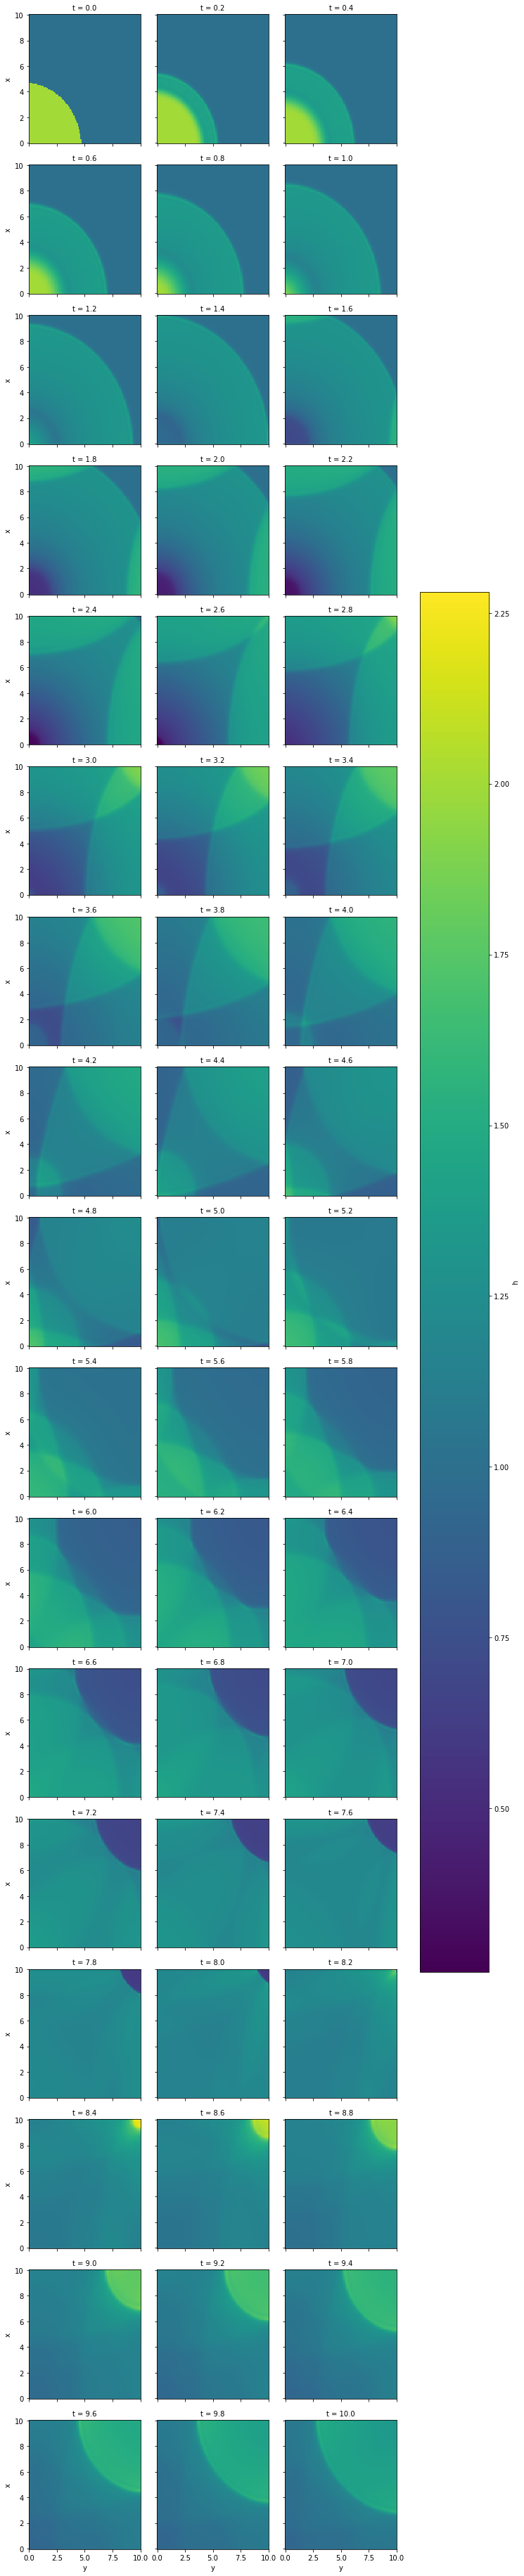

In [8]:
simul = shallow_2D.init_simulation(fields, 0.01, tmax=10, time_stepping=False)
simul.add_post_process("filter", filter_instabilities)
container_shallow = simul.attach_container()
t_max, fields_final = simul.run()

container_shallow.data.h[::20].plot(col="t", col_wrap=3)
plt.savefig("2D_dam_break.png")

<img src="file://../../_static/2D_dam_break.png">




In [9]:
import pylab as pl
import pandas as pd
from skfdiff import Model, Simulation
import numpy as np
from scipy.signal import savgol_filter

shallow_water = Model(["-dx(h * u)", "-upwind(u, u, x, 1) - dxh"], ["h(x)", "u(x)"])

dambreak running: t: 2: : 100it [00:02, 36.96it/s]                          


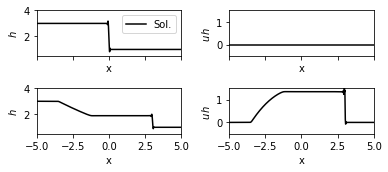

In [11]:
def filter_instabilities(simul):
    simul.fields["h"] = ("x",), savgol_filter(simul.fields["h"], 21, 4)


x, dx = np.linspace(-5, 5, 1000, retstep=True)
h = np.where(x < 0, 3, 1)
u = x * 0

init_fields = shallow_water.Fields(x=x, h=h, u=u)

simul = Simulation(
    shallow_water,
    t=0,
    dt=0.02,
    tmax=2,
    fields=init_fields,
    time_stepping=False,
    id="dambreak",
)

simul.add_post_process("filter", filter_instabilities)

container = simul.attach_container()

simul.run()

data = container.data.sel(t=[0, 0.5, 2], method="nearest")
fig, axs = pl.subplots(2, 2, sharex="all", figsize=(5.5, 2.5))
for i, t in enumerate(data.t):
    if i == 1:
        continue
    if i == 2:
        pl.sca(axs[i - 1, 0])
    else:
        pl.sca(axs[i, 0])
    data.sel(t=t).h.plot(color="black", label="Sol.")
    # ref_data = pd.read_csv("valid_randall/dam_h%i.csv" % i)
    # pl.scatter(ref_data.x, ref_data.h, color="red", marker=".", label="Ref.")
    pl.title("")
    pl.ylabel(r"$h$")
    pl.xlim(-5, 5)
    pl.ylim(0.5, 4)
    if i == 0:
        pl.legend()
    if i == 2:
        pl.sca(axs[i - 1, 1])
    else:
        pl.sca(axs[i, 1])
    (data.sel(t=t).h * data.sel(t=t).u).plot(color="black", label="Sol.")
    # ref_data = pd.read_csv("valid_randall/dam_hu%i.csv" % i)
    # pl.scatter(ref_data.x, ref_data.h, color="red", marker=".", label="Ref.")
    pl.title("")
    pl.ylabel(r"$u\,h$")
    pl.xlim(-5, 5)
    pl.ylim(-0.5, 1.5)
    pl.tight_layout()

pl.show()